# Hand written digits recognition with neural networks using Keras library
## Introduction
+ The following packages need to be installed:
 + The python packages `keras`, `tensorflow`, `numpy` and `matplotlib`.
 + Jupyter notebook


## Preliminary
+ Importing necessary modules : The cell underneath needs to be run before others to import modules.

In [1]:
import keras
from keras.utils        import np_utils
from keras.models       import Sequential
from keras.layers       import Dense, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, BatchNormalization
from keras.datasets     import mnist
from keras.optimizers   import Adam, Adadelta
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


+ Useful functions to reshape the input and watch failed predictions from a model.

In [2]:
def get_input_1D():
    # read data from dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_test_original = x_test
    
    # reshape x in 1D
    x_train = x_train.reshape(x_train.shape[0], 784)
    x_test = x_test.reshape(x_test.shape[0], 784)

    # cast x to float32 and normalize to [0,1]
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    # reshape y to 10-dim bit instead of int
    y_test_original = y_test
    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)

    return x_train, y_train, x_test, y_test
    
    
def get_input_2D():
    # read data from dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # reshape in 2D, 28*28
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

    #convert to float and normalize
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    # reshape y to 10-dim bit instead of int
    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)

    return x_train, y_train, x_test, y_test


def show_failed_cases(model, x_test, y_test, nb_to_show = 20):
    l_1 = model.predict_classes(x_test)
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    l_2 = y_test
    ll = [i for i in range(len(l_1)) if l_1[i] != l_2[i] ]
    failed_sample = [ll[i] for i in random.sample(range(len(ll)), nb_to_show)]
    
    x_test = x_test.reshape(x_test.shape[0], 28, 28)
    for fail in failed_sample:
        plt.figure(fail)
        img = x_test[fail]
        print("real value is %s ; predicted value is %s" % (y_test[fail], l_1[fail]))
        plt.imshow(img)
        plt.show()

def show_history(history):
    #  "Accuracy"
    plt.figure(1)
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    #plt.legend(['train', 'validation'], loc='upper left')
    #plt.show()
    # "Loss"
    plt.figure(2)
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(['train', 'validation'], loc='upper left')
    #plt.show()

## A first neural network : The multi-layer perceptron
+ This first example uses only Dense (fully connected) layers. We used this NN to study the influence of some hyperparameters on an architecture of fully connected layers.

In [3]:
def add_dense_layers(model, dense_layers_sizes, drop_out=None):
    model = Sequential()
    model.add(Dense(dense_layers_sizes[0], input_dim=784, activation='sigmoid'))
    
    for size in dense_layers_sizes[1:]:
        if drop_out:
            model.add(Dropout(drop_out))
        model.add(Dense(size, activation='sigmoid'))
    return model

### Number of dense layers :
+ The first 2 or 3 dense layers do play an important part, but after, adding many layers do not really improve the prediction quality of the model, and has a big cost for the performance. Actually the best results are achieved with the smallest NN, made of only 1 hidden layer.
+ It is interesting to see that if the NN is given too many dense layers, with random values to start with, it cannot "learn" anymore and keep predicting at a very low success rate (about 10%, as good as a random predictor). So it looks that too many layers, with no network structure, does not improve at all the model but diminishes its quality.
+ Tests done on 4 epochs, batch_size 64, layer size of 256

Influence of number of dense layers :
With 1 hidden layers
10000/10000 [==============================] - 1s 60us/step
accuracy : 0.9675 ; loss : 0.12442647863794118
__________________________________

With 2 hidden layers
10000/10000 [==============================] - 1s 66us/step
accuracy : 0.9772 ; loss : 0.08180282568475232
__________________________________

With 3 hidden layers
10000/10000 [==============================] - 1s 74us/step
accuracy : 0.9748 ; loss : 0.0954628941424191
__________________________________

With 4 hidden layers
10000/10000 [==============================] - 1s 88us/step
accuracy : 0.9734 ; loss : 0.09782832835540176
__________________________________

With 5 hidden layers
10000/10000 [==============================] - 1s 92us/step
accuracy : 0.9644 ; loss : 0.13781243025958537
__________________________________



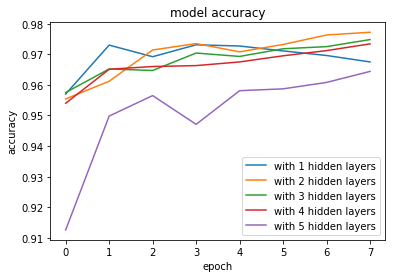

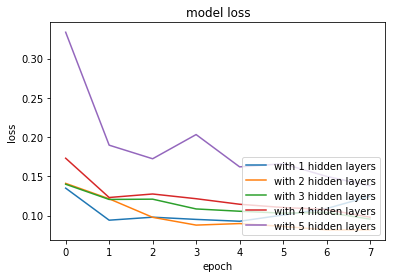

In [6]:
# Influence of number of layers:
print("Influence of number of dense layers :")
x_train, y_train, x_test, y_test = get_input_1D()
layers = [256]
for i in range(5):
    print("With %s hidden layers" % (i+1))
    drop_out = 0.2
    model = Sequential()
    model = add_dense_layers(model, layers, drop_out)
    model.add(Dense(10, activation='softmax'))
    opt=Adam(lr=0.01)
    model.compile(loss = 'categorical_crossentropy',
                 optimizer = opt,
                 metrics = ['accuracy'])

    hist = model.fit(x_train, y_train,
             epochs = 8,
             batch_size = 64,
             verbose=0,
             validation_data=(x_test, y_test))
    
    show_history(hist)
    layers += [256]
    loss, acc = model.evaluate(x_test, y_test, batch_size = 64)
    print("accuracy : %s ; loss : %s" % (acc, loss))
    print("__________________________________\n")
plt.figure(1)
plt.legend(["with %s hidden layers" % (i+1) for i in range(6)], loc=4)
plt.savefig("nb_layers_influence_on_acc.png")
plt.figure(2)
plt.legend(["with %s hidden layers" % (i+1) for i in range(6)], loc=3)
plt.savefig("nb_layers_influence_on_loss.png")
plt.show()

### Size of dense layers :
+ Playing with dense layer size does also have an influence on the results, here is a plot giving results according to different dense layer sizes.
+ We can see that it is not really useful to go for gigantic dense layers, since they don't seem to provide better results than the smaller ones. In this case, we can see that after a layer of size 256, training a NN with a bigger layer does not improve the results, but demands more time to train the NN.
    



Influence of layer size
Layer size : 16

10000/10000 [==============================] - 0s 35us/step
accuracy : 0.9434 ; loss : 0.19799489527344705
__________________________________

Layer size : 32

10000/10000 [==============================] - 0s 40us/step
accuracy : 0.9606 ; loss : 0.14255607817545532
__________________________________

Layer size : 64

10000/10000 [==============================] - 0s 45us/step
accuracy : 0.9663 ; loss : 0.11263958289921283
__________________________________

Layer size : 128

10000/10000 [==============================] - 1s 50us/step
accuracy : 0.9673 ; loss : 0.11383470348902047
__________________________________

Layer size : 256

10000/10000 [==============================] - 1s 63us/step
accuracy : 0.9688 ; loss : 0.10784088404513896
__________________________________

Layer size : 512

10000/10000 [==============================] - 1s 63us/step
accuracy : 0.9707 ; loss : 0.10695573622111115
__________________________________

Layer size 

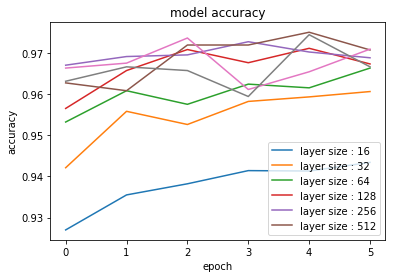

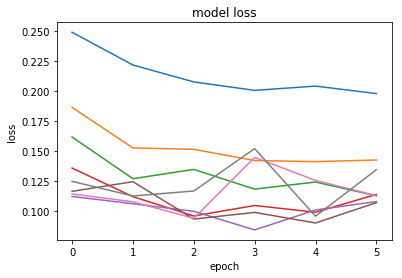

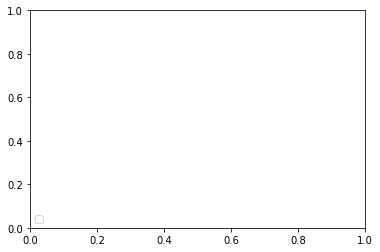

In [7]:
# influence of layer size :
print("\n\nInfluence of layer size")
x_train, y_train, x_test, y_test = get_input_1D()
layers = [16]
for i in range(8):
    print("Layer size : %s\n" % (16*2**i))
    drop_out = 0.2
    model = Sequential()
    model = add_dense_layers(model, layers, drop_out)
    model.add(Dense(10, activation='softmax'))
    opt=Adam(lr=0.01)
    model.compile(loss = 'categorical_crossentropy',
                 optimizer = opt,
                 metrics = ['accuracy'])

    hist = model.fit(x_train, y_train,
             epochs = 6,
             batch_size = 64,
             verbose=0,
             validation_data=(x_test, y_test))
    
    show_history(hist)
    layers = [2*layers[0]]
    loss, acc = model.evaluate(x_test, y_test, batch_size = 64)
    print("accuracy : %s ; loss : %s" % (acc, loss))
    print("__________________________________\n")
plt.figure(1)
plt.legend(["layer size : %s" % (16*2**i) for i in range(6)], loc=4)
plt.savefig("layer_size_influence_on_acc.png")
plt.figure(2)
plt.savefig("layer_size_influence_on_loss.png")
plt.legend(["layer size :%s" % (16*2**i) for i in range(6)], loc=3)
plt.show()

### Number of epochs : 
+ The NN does learn a bit during each epoch ; but this has limits as well, since we can see that a very high number of epochs does not improve the overall results or diminish the overall losses. We can clearly see that on this graph, where after a dozen epochs the NN stops improving and reaches some kind of limit.
+ We can also see that after a number of epochs (in this case a dozen), the model starts overfitting, since the results obtained on the training data are getting better and better, while the results obtained on the validation data do not improve.

Influence of number of epochs
epoch 1
10000/10000 [==============================] - 1s 127us/step
score : acc = 0.9611 ; loss = 0.12144149422198534
epoch 2
10000/10000 [==============================] - 1s 71us/step
score : acc = 0.9674 ; loss = 0.10665528505295516
epoch 3
10000/10000 [==============================] - 1s 54us/step
score : acc = 0.9695 ; loss = 0.09403784801363944
epoch 4
10000/10000 [==============================] - 1s 87us/step
score : acc = 0.9722 ; loss = 0.09269892251007258
epoch 5
10000/10000 [==============================] - 1s 61us/step
score : acc = 0.9731 ; loss = 0.08501770935561508
epoch 6
10000/10000 [==============================] - 1s 59us/step
score : acc = 0.976 ; loss = 0.08704134527165443
epoch 7
10000/10000 [==============================] - 1s 61us/step
score : acc = 0.9741 ; loss = 0.08862000176524744
epoch 8
10000/10000 [==============================] - 1s 59us/step
score : acc = 0.9759 ; loss = 0.08652003655764275
epoch 9
10000/10000 [=====

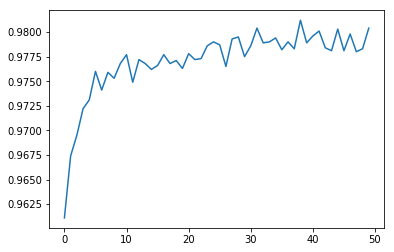

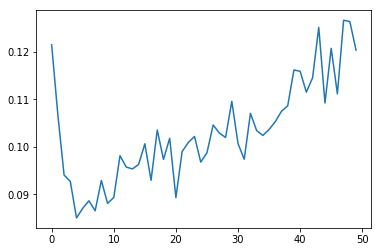

In [8]:
#influence of number of epochs
print("Influence of number of epochs")
model = Sequential()
model.add(Dense(256, input_dim=784, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
opt=Adam(lr=0.01)
model.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])

x_train, y_train, x_test, y_test = get_input_1D()
score_acc, score_loss = [], []
for i in range(50):
    print("epoch %s" % (i+1))
    model.fit(x_train, y_train,
             epochs = 1,
             batch_size = 64,
             verbose=0)
    loss, acc = model.evaluate(x_test, y_test, batch_size = 64)
    score_acc += [acc]
    score_loss += [loss]
    print("score : acc = %s ; loss = %s" % (acc, loss))
plt.plot(score_acc)
plt.show()
plt.plot(score_loss)
plt.show()

#show_failed_cases(model, x_test, y_test)

### Dropout influence :
+ Including dropout layers will prevent overfitting, this feature is really an important one. For a NN to be well trained without any dropout, we obtain better results on the training samples than on the test samples, and vice versa when dropout is enabled. We can also see that the best values in our case for the dropout are around 0.2 / 0.3, meaning that around 20-30% of the cells are desactivated at each iteration.
+ That's why all Dense layers will be added to the model along with a dropout layer to prevent overfitting.

In [ ]:
# Overfitting

x_train, y_train, x_test, y_test = get_input_1D()
score_acc, score_loss = [], []
for i in range(5):
    print("Dropout value : %s" % (0.1*i))
    model = Sequential()
    model.add(Dense(256, input_dim=784, activation='sigmoid'))
    if i != 0:
        model.add(Dropout(0.1*i))
    model.add(Dense(10, activation='softmax'))
    opt=Adam(lr=0.01)
    model.compile(loss = 'categorical_crossentropy',
                 optimizer = opt,
                 metrics = ['accuracy'])

    model.fit(x_train, y_train,
             epochs = 8,
             batch_size = 64)
    loss, acc = model.evaluate(x_test, y_test, batch_size = 64)
    score_acc += [acc]
    score_loss += [loss]
    print("score : acc = %s ; loss = %s" % (acc, loss))
plt.plot(score_acc)
plt.show()
plt.plot(loss_acc)
plt.show()

### In brief
+ We see that a very simple MLP, made of only one hidden layer of size 256, along with a Dropout layer to prevent overfitting, does achieve decent results already. But to recognize images, one need to see features in these images, and that's when we start using convolutional NN.

## Another architecture : using convolutionnal NN
+ In this part, we did use the following architecture :
    + Conv2D
    + Conv2D
    + Dropout
    + MaxPooling2D
    + Flatten
    + Dense
    + Dense
+ By running tests on the values to retain for hyperparameters, we obtained some NN achieving very high accuracy rates. Here is a description of those tests and the obtained results.

### Experiments:

+ Since running the experiment with all the compilation between parameters will take very long time, our procedure was to work on tuning parameters one by one. We change one parameter and fix the others then take the best results and change another parameter.
+ The chosen order to tune paramterers was the following : kernel_size, batch_size, optimizer, loss_function, number_of_epoch. Number_of_epoch was chosen to be the last one so as to finish the experiment in the shortest possible time, running all the previous experiments with 4 epochs.


### kernel size
+ We started with kernel_size. We chose 6 different sizes (3, 5, 7, 9, 11, 13). The results of a serie of runs are shown beneath.
+ We can see that the best results are achieved with kernel of small size (3, 5 and 7)


![influence of kernel size](img/kernel_size.png)

### Batch size
+ Then came batch size : We tried with the values : 32, 64, 128, 256, 512, 1024. The results of a serie of runs are shown below.
+ We get better results with batch size of 32 and 64 mainly. These values are big enough to compute a good gradient, and still let the NN train faster, and have a good amount of updates in an epoch.


![influence of batch size](img/batch_size.png)

### Testing different optimizers
+ We also tried different optimizers supplied with the keras library. Here are some results obtained with different optimizers.


![influence of optimizer](img/optimizer.png)

### Code
+ Here is the code from which we ran all the tests to get good hyperparameters on convolutional NN.

In [ ]:
#!/usr/bin/env python3

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import sys

def solve(loss_function, optimizer, batch_size, kernel_size, epochs):
	num_classes = 10
	# loss_function 	= sys.argv[1]
	# optimizer		= sys.argv[2]
	# batch_size 		= int(sys.argv[3])
	# kernel_size		= int(sys.argv[4])
	# epochs			= int(sys.argv[5])


	optimizers = {
		'Adadelta'	:	keras.optimizers.Adadelta(lr=.01),
		'Adam'		:	keras.optimizers.Adam(lr=.01),
		'Adagrad' 	:	keras.optimizers.Adagrad(lr=0.01),
		'SGD' 		:	keras.optimizers.SGD(lr=0.01),
		'RMSprop' 	:	keras.optimizers.RMSprop(lr=0.01),
		'Adamax'	:	keras.optimizers.Adamax(lr=.01),
		'Nadam'		:	keras.optimizers.Nadam(lr=.01),
	}



	# input image dimensions
	img_rows, img_cols = 28, 28

	# the data, split between train and test sets
	(x_train, y_train), (x_test, y_test) = mnist.load_data()


	x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
	x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
	input_shape = (img_rows, img_cols, 1)

	x_train = x_train.astype('float32')
	x_test = x_test.astype('float32')
	x_train /= 255
	x_test /= 255
	print('x_train shape:', x_train.shape)
	print(x_train.shape[0], 'train samples')
	print(x_test.shape[0], 'test samples')

	# print ("Bashar")
	# convert class vectors to binary class matrices
	y_train = keras.utils.to_categorical(y_train, num_classes)
	y_test = keras.utils.to_categorical(y_test, num_classes)

	model = Sequential()
	model.add(Conv2D(32, kernel_size=(kernel_size, kernel_size),
	                 activation='relu',
	                 input_shape=input_shape))

	model.add(Conv2D(64, (kernel_size, kernel_size), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dropout(0.5))
	model.add(Dense(num_classes, activation='softmax'))

	model.compile(loss=loss_function,
	              optimizer=keras.optimizers.Adadelta(),
	              metrics=['accuracy'])

	model.fit(x_train, y_train,
	          batch_size=batch_size,
	          epochs=epochs,
	          verbose=1,
	          validation_data=(x_test, y_test))

	score = model.evaluate(x_test, y_test, verbose=0)
	# # model.summary()

	print('Test loss:', score[0])
	print('Test accuracy:', score[1])

	return [score[0], score[1]]


file = open("parameter.csv", "r")
line = '1'
while line:
	results_file = open("results.csv", "a") 	

	line = file.readline()
	results_file.write(line.replace('\n','') + ",")
	params = line.split(',')
	
	[loss, accuracy] = solve(params[0], params[1], int(params[2]), int(params[3]), int(params[4]))

	results_file.write(str(loss)+",")
	results_file.write(str(accuracy) + "\n")

	results_file.close()

# solve("categorical_crossentropy", "Adadelta", 128, 3, 12)

#params


## Using data augmentation techniques
+ The keras library is really convenient to use, and data augmentation can be made in just a couple of lines using this library. Here is an example of data augmentation done, with decently chose parameters (little rotations, no flippping/mirroring ...)
+ This is another feature preventing overfitting, since with it the training samples are different on each epoch.

In [ ]:
# read data from dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape in 2D, 28*28
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

#convert to float and normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# reshape y to 10-dim bit instead of int
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)



gen = ImageDataGenerator(rotation_range=11, width_shift_range=0.14, shear_range=0.25,
                         height_shift_range=0.14, zoom_range=0.12)

test_gen = ImageDataGenerator()

train_generator = gen.flow(x_train, y_train, batch_size=64)
test_generator = test_gen.flow(x_test, y_test, batch_size=64)


model = Sequential()
 
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

opt = Adam(lr = 0.01)
model.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])
model.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=5, 
                    validation_data=test_generator, validation_steps=10000//64)
score = model.evaluate(x_test, y_test, batch_size = 64)
print(score)

Adding more conv2D layers, with more filters to improve results.

In [ ]:
# read data from dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape in 2D, 28*28
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

#convert to float and normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# reshape y to 10-dim bit instead of int
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)



gen = ImageDataGenerator(rotation_range=11, width_shift_range=0.14, shear_range=0.25,
                         height_shift_range=0.14, zoom_range=0.12)

test_gen = ImageDataGenerator()

train_generator = gen.flow(x_train, y_train, batch_size=64)
test_generator = test_gen.flow(x_test, y_test, batch_size=64)


model = Sequential()
 
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
#model.add(BatchNormalization(axis=-1))
#model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(BatchNormalization(axis=-1))
#model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
#model.add(BatchNormalization())
#model.add(Dense(24, activation='relu'))
model.add(Dense(10, activation='softmax'))

#opt = Adam(lr = 0.015)
opt = Adadelta()
model.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])
model.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=10, 
                    validation_data=test_generator, validation_steps=10000//64)
score = model.evaluate(x_test, y_test, batch_size = 64)
print(score)